In [1]:
import shutil
import os
from glob import glob

import pydicom as dicom
from pydicom.data import get_testdata_file

import numpy as np # linear algebra
import pandas as pd
import natsort
from IPython.display import Image
import matplotlib.pyplot as plt
import math
import seaborn as sns
from skimage import exposure # for histogram equalization
import scipy.stats as stats
import cv2

from scipy import ndimage

import radiomics
from radiomics import featureextractor

import SimpleITK as sitk
import six
from SimpleITK import GetImageFromArray
from radiomics.featureextractor import RadiomicsFeatureExtractor # This module is used for interaction with pyradiomic
import logging
logging.getLogger('radiomics').setLevel(logging.CRITICAL + 1)  # this tool makes a whole TON of log noise

import math

import tifffile as tiff
from tifffile import imsave

In [2]:
# Import datasets

PATH = 'D:/style transfer/code/MRI_stan/dataset/'

stan = pd.read_excel(PATH+'/standard_T1_1000.xlsx')
#stand = pd.read_excel(PATH+'/train/standard_T1.xlsx') #8010
stan = stan.iloc[np.random.permutation(stan.index)].reset_index(drop=True) 

nstan1 = pd.read_excel(PATH+'/train/OSF_T1_train.xlsx') 
nstan2 = pd.read_excel(PATH+'/train/nonstan_T1_train.xlsx', usecols = ['Path']) 
nstan = pd.concat([nstan1, nstan2], axis=0).reset_index(drop=True)
non_stan = nstan.iloc[np.random.permutation(nstan.index)].reset_index(drop=True) 

In [3]:
# Setting radiomics

params = {}
params['binCount'] = 32
params['sigma'] = [1, 2, 3]
params['verbose'] = False

# Instantiate the extractor
extractor = RadiomicsFeatureExtractor(**params)# ** 'unpacks' the dictionary in the function call

#texture_extractor = RadiomicsFeatureExtractor(verbose=False)
extractor.disableAllFeatures()
_text_feat = {ckey: [] for ckey in extractor.featureClassNames}
extractor.enableFeaturesByName(**_text_feat)

In [4]:
from scipy.stats import t

def calc_radiomics(in_image_data):
    return extractor.execute(GetImageFromArray(in_image_data), GetImageFromArray((in_image_data>0.).astype(np.uint8)))

def ae(x,y):
    return np.abs(x - y)/y

def CI(x):
    m = np.array(x).mean()
    s = np.array(x).std() 
    dof = len(x)-1 
    confidence = 0.95
    t_crit = np.abs(t.ppf((1-confidence)/2,dof))
    return s*t_crit/np.sqrt(len(x)) 

In [5]:
img_size = (320,320)
img_size_c = (120,320)

def dicom_to_array(path):
    d = dicom.dcmread(path)
    a = d.pixel_array
    return np.array(a)

def read(path, img_size):    
    dcm = dicom.dcmread(path)
    img = dcm.pixel_array      
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_LINEAR)
    img = normalize(img)
    return np.squeeze(np.stack([img[np.newaxis,:,:]])) 

def normalize(img):  #0~1 float
    if img.max() == img.min():
        return np.zeros(img.shape)
    return ((img - img.min())/(img.max() - img.min()))*255

def read_tif(path, img_size):    
    img = tiff.imread(path)
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_LINEAR)   
    img = normalize(img)
    return np.squeeze(np.stack([img[np.newaxis,:,:]])) 

In [6]:
# ROI of target (standard) images

stan_crop = []
for i in range(len(stan)):
    a = read(stan['Path'].iloc[i],img_size)
    img = a.astype(np.uint8)
    #applying canny edge detection
    edged = cv2.Canny(img, 250, 255)

    #finding contours
    (cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(c) for c in cnts]

    #Calculate the combined bounding rectangle points.
    top_x = min([x for (x, y, w, h) in rects])
    top_y = min([y for (x, y, w, h) in rects])
    bottom_x = max([x+w-40 for (x, y, w, h) in rects])
    bottom_y = max([y+h-40 for (x, y, w, h) in rects])
    #c_img = img[top_y:bottom_y,top_x:bottom_x]
    if (bottom_x - top_x >= 150):
        crop_img = img[top_y:bottom_y,bottom_x-130:bottom_x]
    else: crop_img = img[top_y:bottom_y,top_x:bottom_x]
    #crop_img = cv2.resize(crop_img, img_size_c, interpolation=cv2.INTER_NEAREST)
    crop_img = normalize(crop_img)
    stan_crop.append(crop_img)

In [ ]:
length = len(stan_crop)
l = math.ceil(round(length/(10**(len(str(length))-1)),1))
l = l*10**(len(str(length))-3)

plt.figure(figsize=(20,20*l))
plt.gray()
plt.subplots_adjust(hspace = 0.2, wspace = 0.01)
for i in range(length):
     plt.subplot(10*l,10,i+1), plt.imshow(stan_crop[i]), plt.axis('off'), plt.title(str(i))
plt.show()

In [7]:
# Calculate the RF values from 1000 ROIs of target images

m = 1000

# df_s = pd.DataFrame()
# for i in range(m):
#     img =  read(stan['Path'].iloc[i], img_size)
#     results = calc_radiomics(img)
#     dat = pd.DataFrame([results])
#     df_s = pd.concat([df_s,dat])

df_s = pd.DataFrame()
for i in range(len(stan_crop)):
    results = calc_radiomics(stan_crop[i])
    dat = pd.DataFrame([results])
    df_s = pd.concat([df_s,dat])

In [8]:
# Cacluate the mean, STD, and CV (Coefficient of Variation)

stn = df_s.loc[:,df_s.columns.str.contains("firstorder|glcm|gldm|glrlm|glszm")]
stn = stn.drop(['original_firstorder_10Percentile','original_firstorder_Maximum','original_firstorder_Minimum','original_firstorder_Range'], axis=1)

stn.loc['mean'] = stn.mean()
stn.loc['STD'] = stn.std()
stn.loc['CV'] = stn.loc['STD'] / stn.loc['mean'] *100
stn.columns = stn.columns.str.replace("original_","")

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
display(stn)

## 1. CV (Coefficient of Variation)

Text(0, 0.5, '')

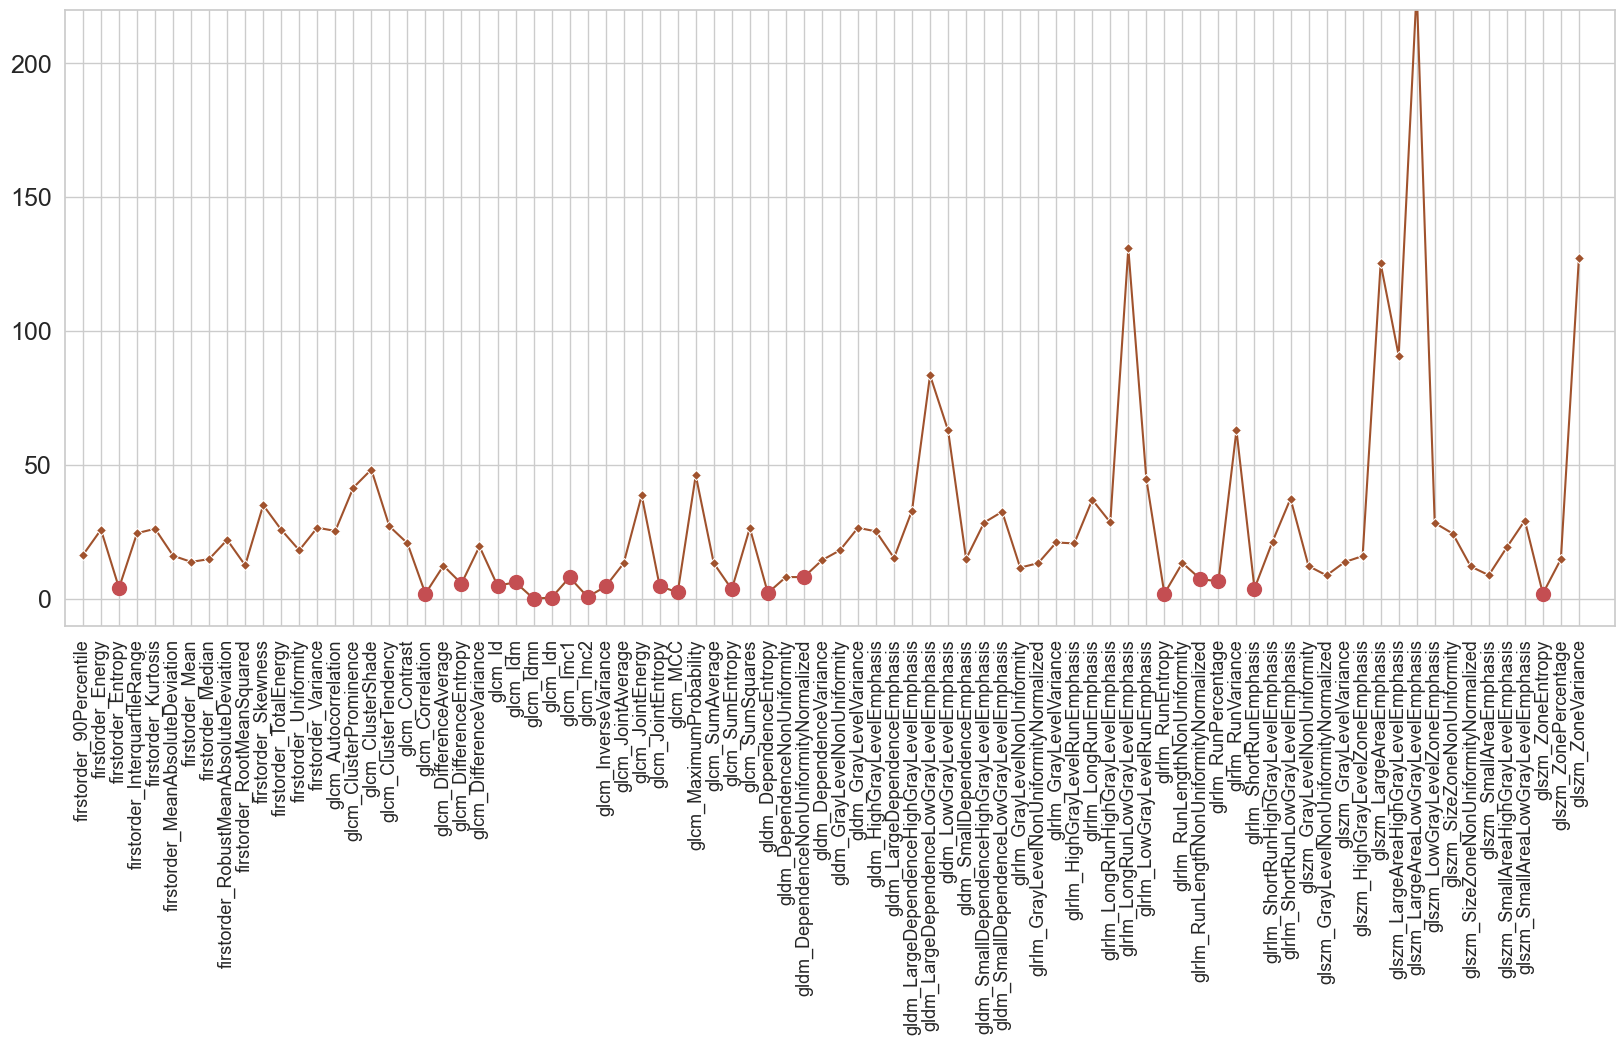

In [10]:
plt.figure(figsize = (20,8))
sns.set_theme(style="whitegrid")

dat = stn.loc['CV',:]
dat = dat.astype(float)
lists = dat.nsmallest(20)

g = sns.lineplot(data=np.abs(dat), color= 'sienna',  marker='D', markersize=5)

plt.plot(lists.index, np.abs(lists), 'ro', markersize=10)

plt.xticks(rotation=90, fontsize = 13)
plt.yticks(fontsize = 18)
g.set(xlim=(-1,85),ylim=(-10,220))
g.set_ylabel('') 

#plt.xticks(lists.index, rotation=90, fontsize = 12, color='red')

#g.set_xticklabels(rotation=90)
#g.set(xticklabels=[])
#g1.set(xlabel=None)
# g.set_xlabel("Radiomics Features", fontsize = 20)
# g.set_ylabel("Coefficient of Variation", fontsize = 20)

In [11]:
lists = dat.nsmallest(30)
lists

glcm_Imc1                                 -8.049925
glcm_Idmn                                  0.112767
glcm_Idn                                   0.477568
glcm_Imc2                                  0.727427
glrlm_RunEntropy                           1.954320
glcm_Correlation                           1.956238
glszm_ZoneEntropy                          1.991897
gldm_DependenceEntropy                     2.207633
glcm_MCC                                   2.466247
glcm_SumEntropy                            3.569836
glrlm_ShortRunEmphasis                     3.875316
firstorder_Entropy                         4.096827
glcm_InverseVariance                       4.636676
glcm_JointEntropy                          4.711938
glcm_Id                                    4.975519
glcm_DifferenceEntropy                     5.714779
glcm_Idm                                   6.165928
glrlm_RunPercentage                        6.529751
glrlm_RunLengthNonUniformityNormalized     7.424927
gldm_Depende

## 2. Correlation (>=0.8)

In [9]:
corr_mat = stn.astype('float64').corr().abs().stack().reset_index(name="correlation")

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
fil_corr8 = corr_mat[(corr_mat['correlation'] >= 0.8)].reset_index(drop=True) #311
display(fil_corr8)

In [19]:
# List of top 20 RFs with smallest CV

lists20 = ['glcm_Idmn','glcm_Idn','glcm_Imc2','glrlm_RunEntropy','glcm_Correlation','glszm_ZoneEntropy',
           'gldm_DependenceEntropy','glcm_MCC','glcm_SumEntropy','glrlm_ShortRunEmphasis','firstorder_Entropy',
           'glcm_InverseVariance','glcm_JointEntropy','glcm_Id','glcm_DifferenceEntropy','glcm_Idm','glrlm_RunPercentage',
           'glrlm_RunLengthNonUniformityNormalized','glcm_Imc1','gldm_DependenceNonUniformityNormalized']

C:\Users\MNL\AppData\Local\Temp\ipykernel_16024\1811330420.py:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for artist in g.legend.legendHandles:


<Figure size 2000x2000 with 0 Axes>

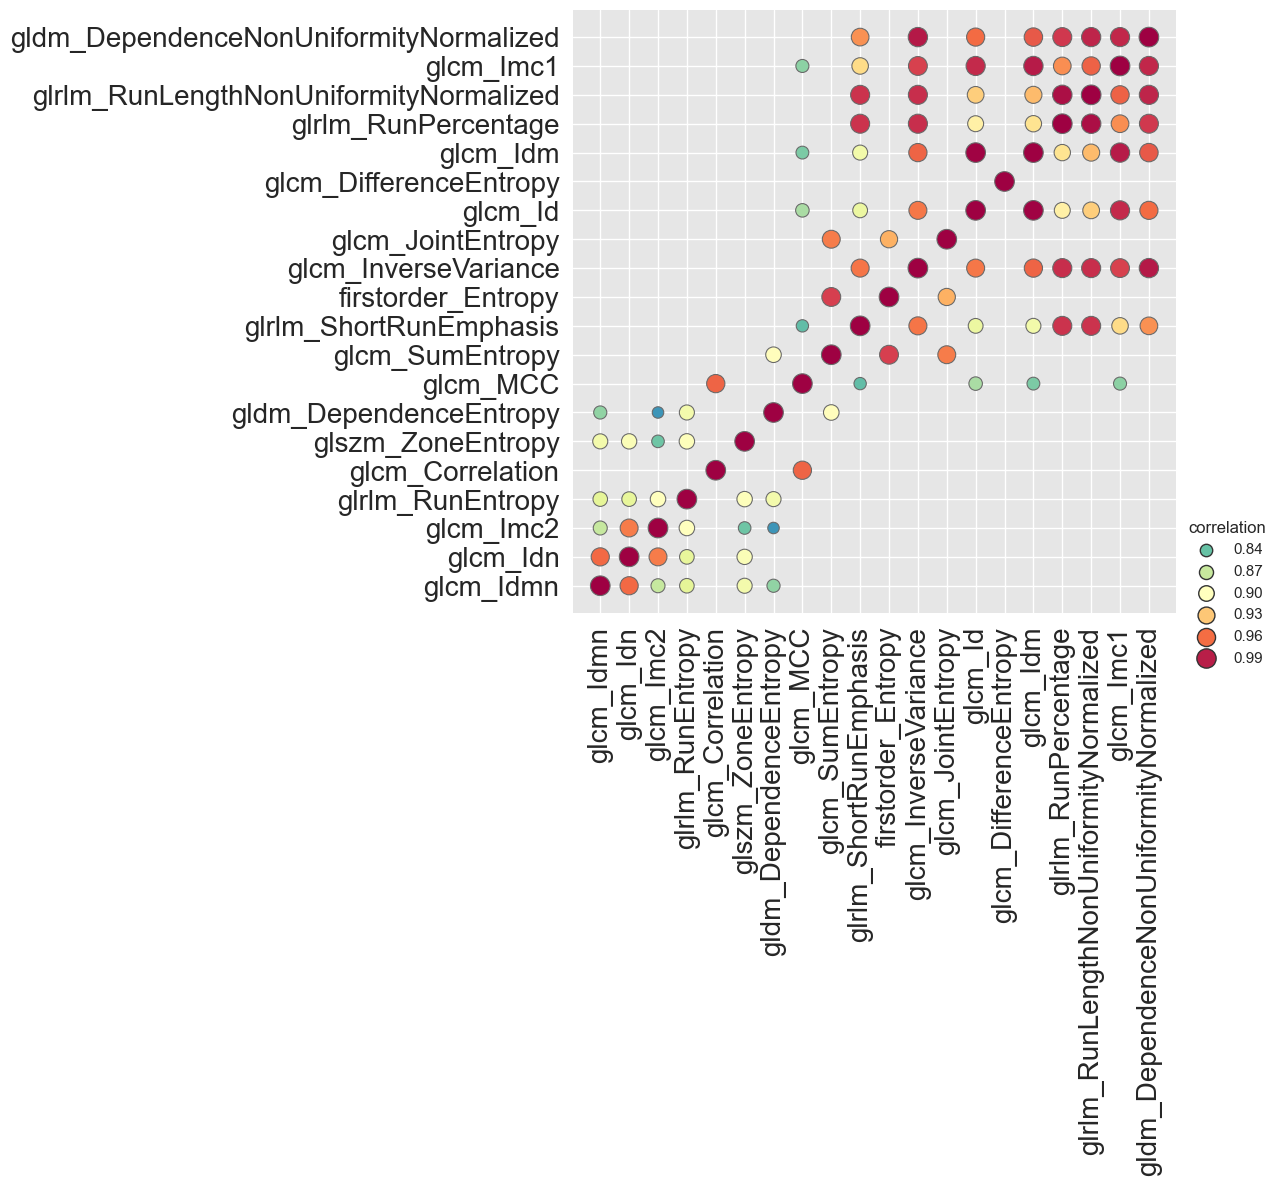

In [20]:
# Display the correlation results between top 20 RFs

threshold = 0.82

plt.figure(figsize=(20,20))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
# Compute a correlation matrix and convert to long-form
corr_mat = stn[lists20].astype('float64').corr().abs().stack().reset_index(name="correlation")
corr_mat['correlation'].mask(corr_mat['correlation'] < threshold, None, inplace=True)

# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation", 
    palette="Spectral_r", hue_norm=(0.8, 1.0),edgecolor="dimgray",
    height=10, sizes=(50, 200), size_norm=(0.8, 1.0))

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.05)

for label in g.ax.get_xticklabels():
    label.set_rotation(90)
    label.set_fontsize(20)
    
for label in g.ax.get_yticklabels():
    label.set_fontsize(20)
    
for artist in g.legend.legendHandles:
    artist.set_edgecolor("0.2")
g.ax.invert_yaxis()

C:\Users\MNL\AppData\Local\Temp\ipykernel_24492\667665267.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for artist in g.legend.legendHandles:


<Figure size 2000x3200 with 0 Axes>

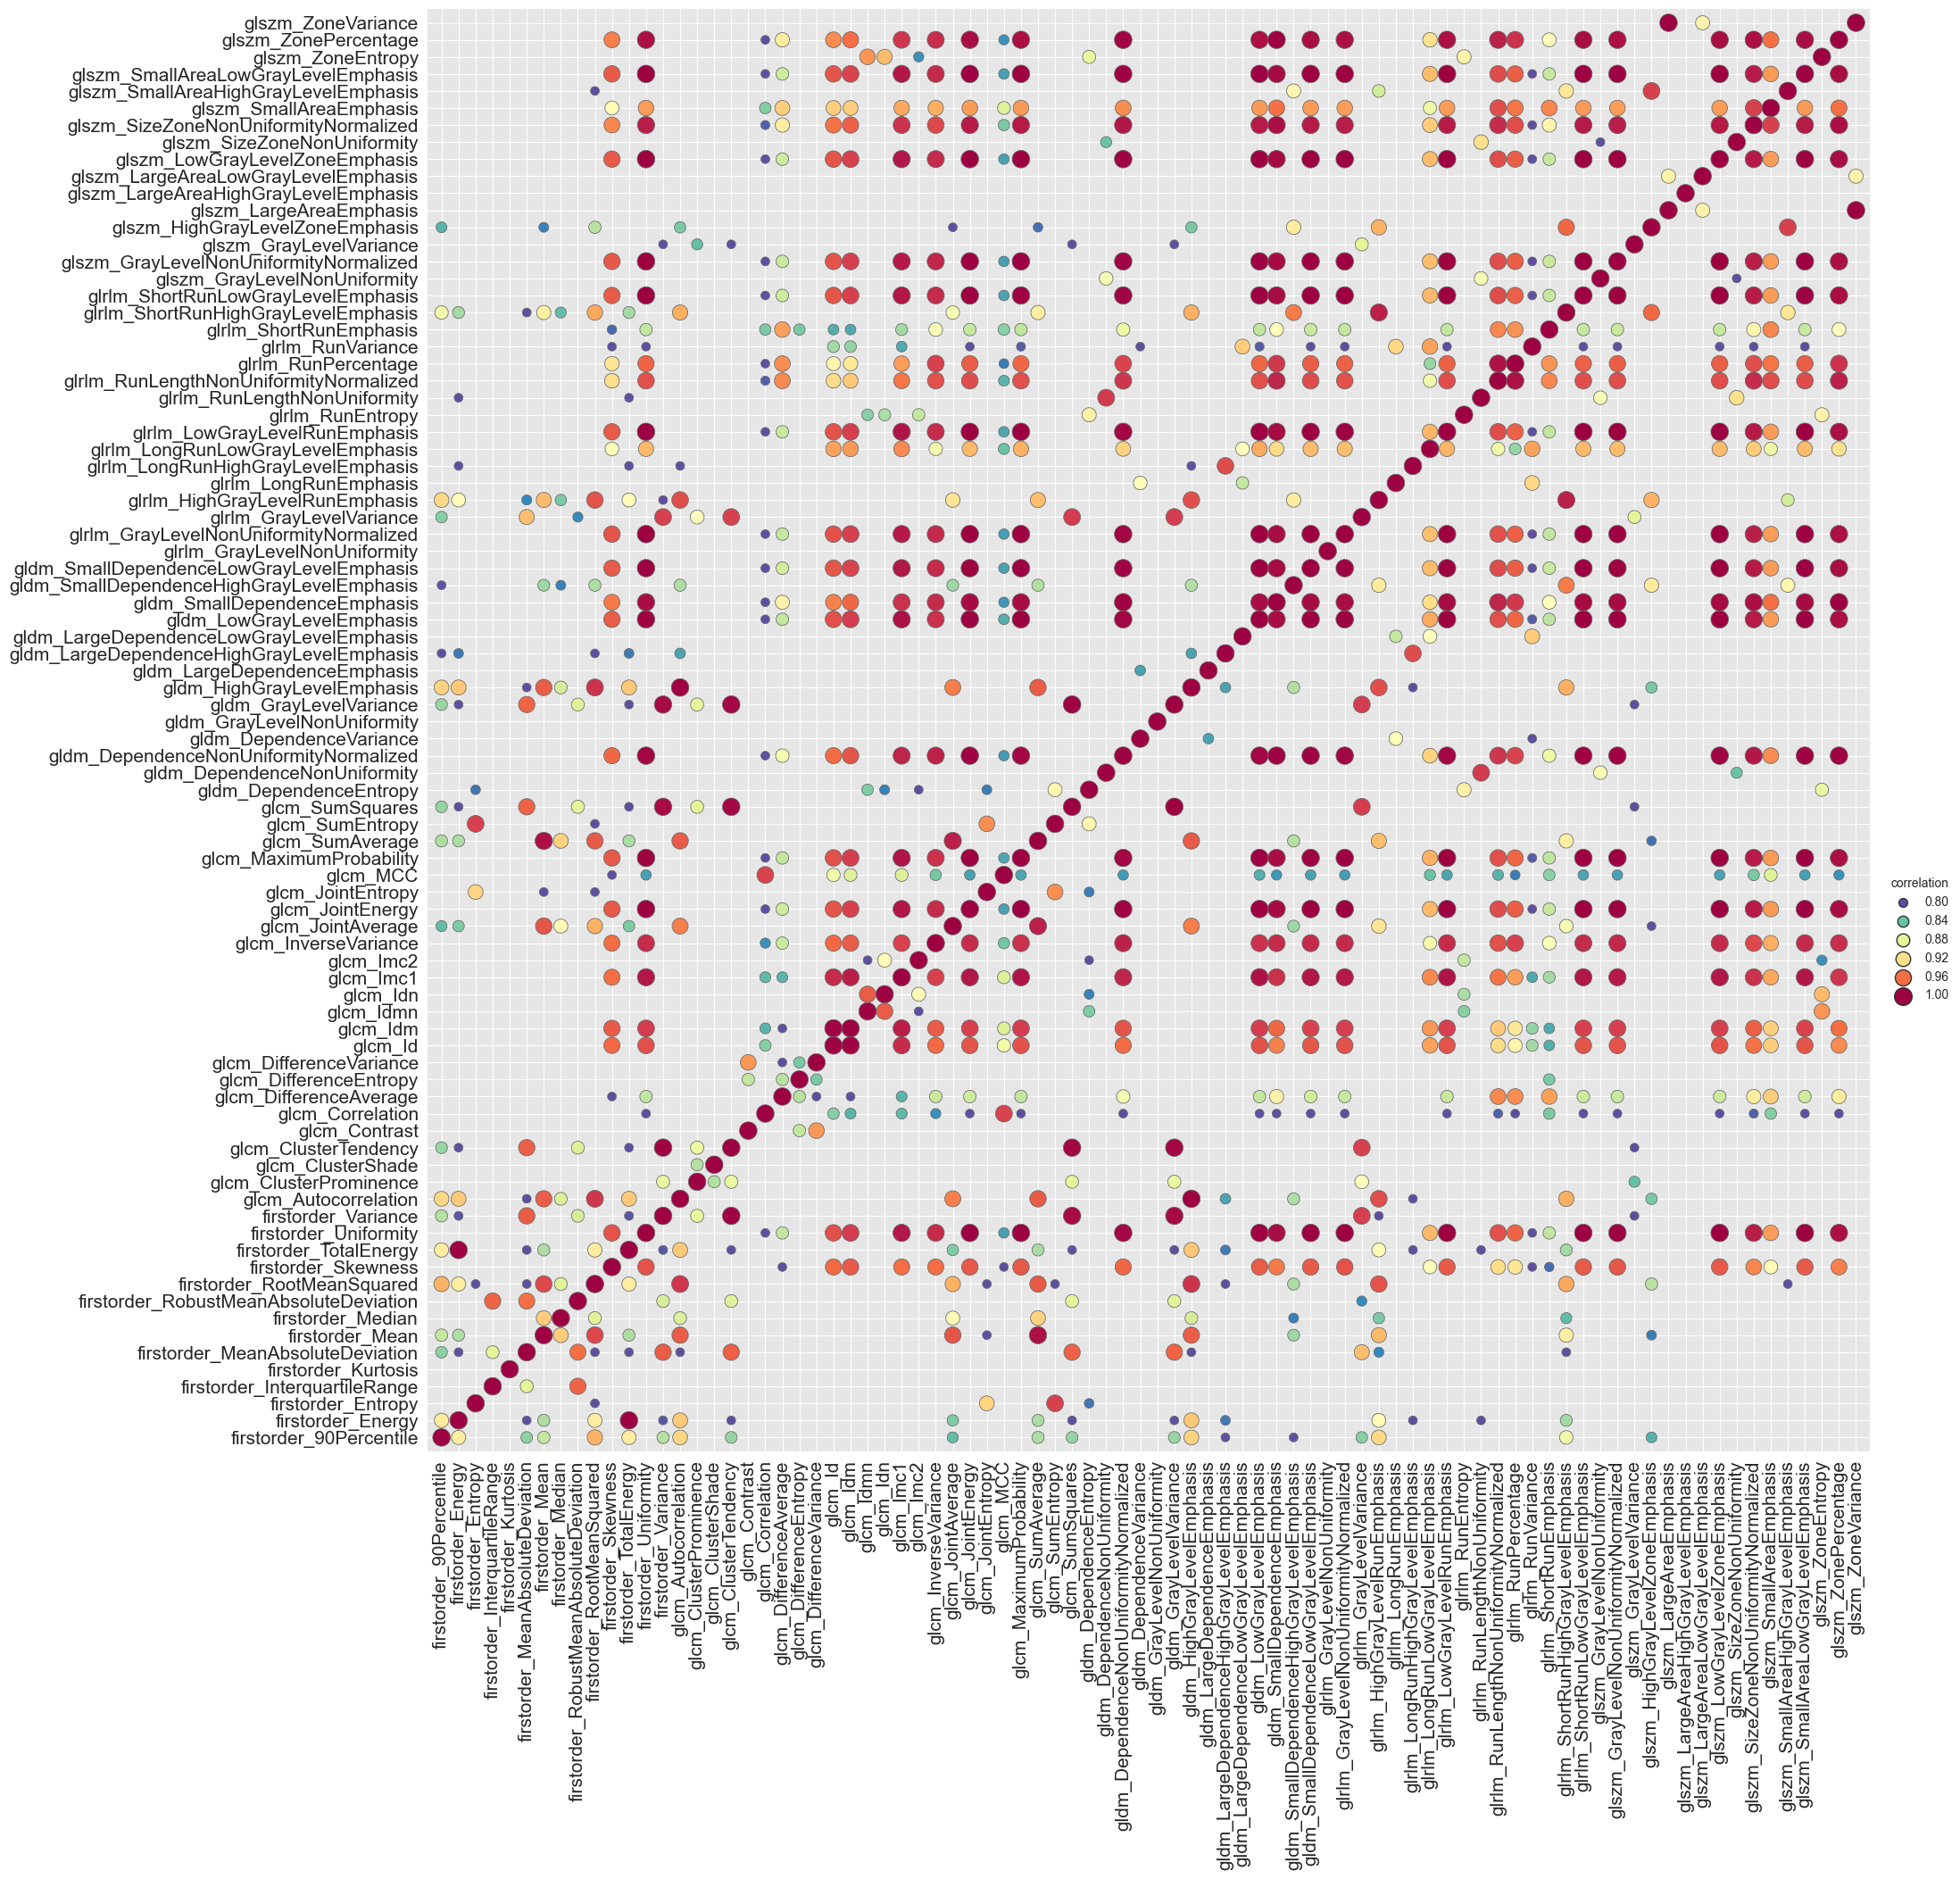

In [12]:
# Display the correlation results between all RFs

threshold = 0.78

plt.figure(figsize=(20,32))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
# Compute a correlation matrix and convert to long-form
corr_mat = stn.astype('float64').corr().abs().stack().reset_index(name="correlation")
corr_mat['correlation'].mask(corr_mat['correlation'] <= threshold, None, inplace=True)
# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation", 
    palette="Spectral_r", hue_norm=(0.8, 1.0),edgecolor="dimgray",
    height=20, sizes=(50, 200), size_norm=(0.8, 1.0))

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.01)

for label in g.ax.get_xticklabels():
    label.set_rotation(90)
    label.set_fontsize(15)
    
for label in g.ax.get_yticklabels():
    label.set_fontsize(15)
    
for artist in g.legend.legendHandles:
    artist.set_edgecolor("0.2")
g.ax.invert_yaxis()

## Save five RFs selected by two statistics (CV and correlation)

In [11]:
lists = ['glcm_Idmn','glcm_Correlation','glcm_SumEntropy','glrlm_ShortRunEmphasis','glcm_DifferenceEntropy']
         
stn_eval = stn[lists]
stn_eval = stn_eval.loc[['mean']]
stn_eval = stn_eval.astype(float)

path = 'D:/style transfer/code/MRI_stan/dataset/'
standard_path = path+'/standard_RF5.npy'
np.save(standard_path, [stn_eval])

## Comparison of RF values of target (standard) and source (non-standard)

In [ ]:
stn_RF = stn[lists20].transpose()
#stan_RF = stn_RF.loc['mean',:]
# stan_RF = stan_RF.astype(float)
stn_RF.insert(0,'Type','Standard')
stn_RF = stn_RF.drop(['mean','STD','CV'], axis=1)

In [23]:
stn_dp = stn[lists20]
stn_dp

,glcm_Imc1,glcm_Idmn,glcm_Idn,glcm_MCC,glcm_Imc2,glcm_Correlation,glszm_ZoneEntropy,glrlm_RunEntropy,glrlm_ShortRunEmphasis,glszm_SmallAreaEmphasis,glcm_Id,glcm_Idm,glrlm_RunLengthNonUniformityNormalized,glszm_SizeZoneNonUniformityNormalized,glcm_DifferenceEntropy,gldm_DependenceEntropy,glcm_SumEntropy,firstorder_Entropy,glcm_JointEntropy,glszm_GrayLevelNonUniformityNormalized
0,-0.49077573804387914,0.9970533418795589,0.9795124829763427,0.9729000559427188,0.9744713934879791,0.9360469818228117,6.800709711299799,5.940506011116117,0.6770494781917558,0.6091840487317713,0.7847790451625853,0.7691006655194396,0.42725697400702606,0.34605076655298606,1.60787377556942,5.496329186891818,3.77603012564749,3.085569882867117,4.670326641963079,0.051870061716377425
0,-0.47129491889334296,0.9962655230331556,0.971502874183574,0.972837392147419,0.9882240526845676,0.9659710297503522,7.060967553662585,6.097374454827123,0.7068056603305225,0.6043654818699106,0.6958941673354149,0.6716401842221783,0.46497519407867316,0.3397356909477151,1.9392665773315398,6.829287161035641,4.905986985137619,4.052880473141013,6.210864000619318,0.043319942766954375
0,-0.4892932263835444,0.9971181164003478,0.9757992835599553,0.9749556728501018,0.9859002619784575,0.9645866539587635,7.066716019863589,6.072543541130993,0.6761290806497859,0.5797170940426607,0.7311004186040653,0.71123235276003,0.4264831583347792,0.3151107293136901,1.7767852651382958,6.470546330221099,4.517616389361768,3.7140823852117517,5.6258410797680725,0.046891783245478005
0,-0.5041040576484727,0.9979210283922277,0.9782601878334423,0.9780050609853931,0.9878009320550422,0.9716888227291953,7.421964237021297,5.99144353408923,0.6467023075985983,0.5169421473379554,0.7280184289947835,0.7121460428632425,0.3945567766586241,0.256893783790533,1.6300561126618942,6.632598063634198,4.591409741225803,3.740475471461562,5.604752800499081,0.047357408632895906
0,-0.4932545546697328,0.9973211689879169,0.9783922828685722,0.9769244137838,0.9792493313733373,0.9626519145586506,6.878820547639684,6.041327760476726,0.6910126596160763,0.5968008000476812,0.7672229769267267,0.748643332918352,0.4437844713464723,0.33155319618396717,1.6820271160261395,5.712590436894093,3.979373897671319,3.2801581846283834,4.957375410533006,0.051534595389384166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.5053742365608599,0.9977871356435387,0.9807715896721896,0.9775386153032879,0.9788866576535906,0.9503308749164987,7.151870488322015,5.876554352383459,0.6418875864532113,0.5279032637941711,0.7742013668386261,0.7605559033604491,0.38780194112779276,0.2664998278633894,1.546227948241033,5.833183156877732,3.929301133853535,3.1876960729512156,4.776134697546716,0.057559970446868045
0,-0.49091083941028146,0.9966312333895134,0.9719657763842359,0.9795338573178081,0.9920905110482527,0.9749459058941425,7.116436456902059,6.260617445390568,0.6909327577420701,0.603601983435221,0.6904652177422177,0.6671366932314666,0.44355562409237836,0.3389548306448051,1.9118994273372012,7.164076131815423,5.175461149260208,4.283340928934823,6.473304797451636,0.04122440397352205
mean,-0.48862,0.997143,0.975849,0.975497,0.984955,0.963671,7.082527,6.052065,0.681833,0.578132,0.730007,0.710197,0.434148,0.313575,1.762862,6.413249,4.519688,3.711244,5.62369,0.047532
STD,0.023074,0.00051,0.003063,0.004616,0.005131,0.008855,0.110155,0.118283,0.018872,0.017965,0.032521,0.035259,0.023085,0.017837,0.122076,0.484585,0.399283,0.334526,0.525499,0.005007


In [24]:
nstn_RF = nstn[lists20].transpose()
#nstn_RF = nstn_RF.loc['mean',:]
# nstn_RF = nstn_RF.astype(float)
nstn_RF.insert(0,'Type','Non-standard')
nstn_RF = nstn_RF.drop(['mean','STD','CV'], axis=1)

In [25]:
nstn_dp = nstn[lists20]
nstn_dp

,glcm_Imc1,glcm_Idmn,glcm_Idn,glcm_MCC,glcm_Imc2,glcm_Correlation,glszm_ZoneEntropy,glrlm_RunEntropy,glrlm_ShortRunEmphasis,glszm_SmallAreaEmphasis,glcm_Id,glcm_Idm,glrlm_RunLengthNonUniformityNormalized,glszm_SizeZoneNonUniformityNormalized,glcm_DifferenceEntropy,gldm_DependenceEntropy,glcm_SumEntropy,firstorder_Entropy,glcm_JointEntropy,glszm_GrayLevelNonUniformityNormalized
0,-0.49077573804387914,0.9970533418795589,0.9795124829763427,0.9729000559427188,0.9744713934879791,0.9360469818228117,6.800709711299799,5.940506011116117,0.6770494781917558,0.6091840487317713,0.7847790451625853,0.7691006655194396,0.42725697400702606,0.34605076655298606,1.60787377556942,5.496329186891818,3.77603012564749,3.085569882867117,4.670326641963079,0.051870061716377425
0,-0.47129491889334296,0.9962655230331556,0.971502874183574,0.972837392147419,0.9882240526845676,0.9659710297503522,7.060967553662585,6.097374454827123,0.7068056603305225,0.6043654818699106,0.6958941673354149,0.6716401842221783,0.46497519407867316,0.3397356909477151,1.9392665773315398,6.829287161035641,4.905986985137619,4.052880473141013,6.210864000619318,0.043319942766954375
0,-0.4892932263835444,0.9971181164003478,0.9757992835599553,0.9749556728501018,0.9859002619784575,0.9645866539587635,7.066716019863589,6.072543541130993,0.6761290806497859,0.5797170940426607,0.7311004186040653,0.71123235276003,0.4264831583347792,0.3151107293136901,1.7767852651382958,6.470546330221099,4.517616389361768,3.7140823852117517,5.6258410797680725,0.046891783245478005
0,-0.5041040576484727,0.9979210283922277,0.9782601878334423,0.9780050609853931,0.9878009320550422,0.9716888227291953,7.421964237021297,5.99144353408923,0.6467023075985983,0.5169421473379554,0.7280184289947835,0.7121460428632425,0.3945567766586241,0.256893783790533,1.6300561126618942,6.632598063634198,4.591409741225803,3.740475471461562,5.604752800499081,0.047357408632895906
0,-0.4932545546697328,0.9973211689879169,0.9783922828685722,0.9769244137838,0.9792493313733373,0.9626519145586506,6.878820547639684,6.041327760476726,0.6910126596160763,0.5968008000476812,0.7672229769267267,0.748643332918352,0.4437844713464723,0.33155319618396717,1.6820271160261395,5.712590436894093,3.979373897671319,3.2801581846283834,4.957375410533006,0.051534595389384166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.49091083941028146,0.9966312333895134,0.9719657763842359,0.9795338573178081,0.9920905110482527,0.9749459058941425,7.116436456902059,6.260617445390568,0.6909327577420701,0.603601983435221,0.6904652177422177,0.6671366932314666,0.44355562409237836,0.3389548306448051,1.9118994273372012,7.164076131815423,5.175461149260208,4.283340928934823,6.473304797451636,0.04122440397352205
0,-0.6380928763459545,0.9996155905808406,0.9943130548576142,0.9628981842740546,0.9554218978615551,0.9557861117933858,6.715491098897664,6.009791686803355,0.47110676809846863,0.45283318134452244,0.9214226010702259,0.9182737158815051,0.22165693674875053,0.20503262864895722,0.7309988827060596,3.686784363296744,2.371076155744246,1.9233584853164283,2.634102626900725,0.10344323104152806
mean,-0.488769,0.997145,0.975868,0.975484,0.984925,0.963663,7.082161,6.052023,0.681623,0.578007,0.730198,0.710405,0.433936,0.313466,1.761831,6.410525,4.517541,3.709458,5.620703,0.047588
STD,0.023541,0.000516,0.003116,0.004631,0.005213,0.008855,0.110709,0.118231,0.020003,0.018387,0.033063,0.035849,0.02403,0.018154,0.126294,0.491941,0.404815,0.339096,0.53366,0.005307


In [21]:
cdf = pd.concat([stn_RF, nstn_RF], axis=0)    
cdf.index.names = ['RF']
#stan_RF = stan_RF.set_index('col1').T.rename_axis('RF').rename_axis(None, 1)
# stan_RF.T.set_axis(["category", "product", "price"], axis=1, inplace=False).rename_axis('RF',axis=0)
cdf.reset_index(inplace=True)

mdf = pd.melt(cdf, id_vars=['RF', 'Type'])
mdf['value'] = mdf['value'].astype(float)

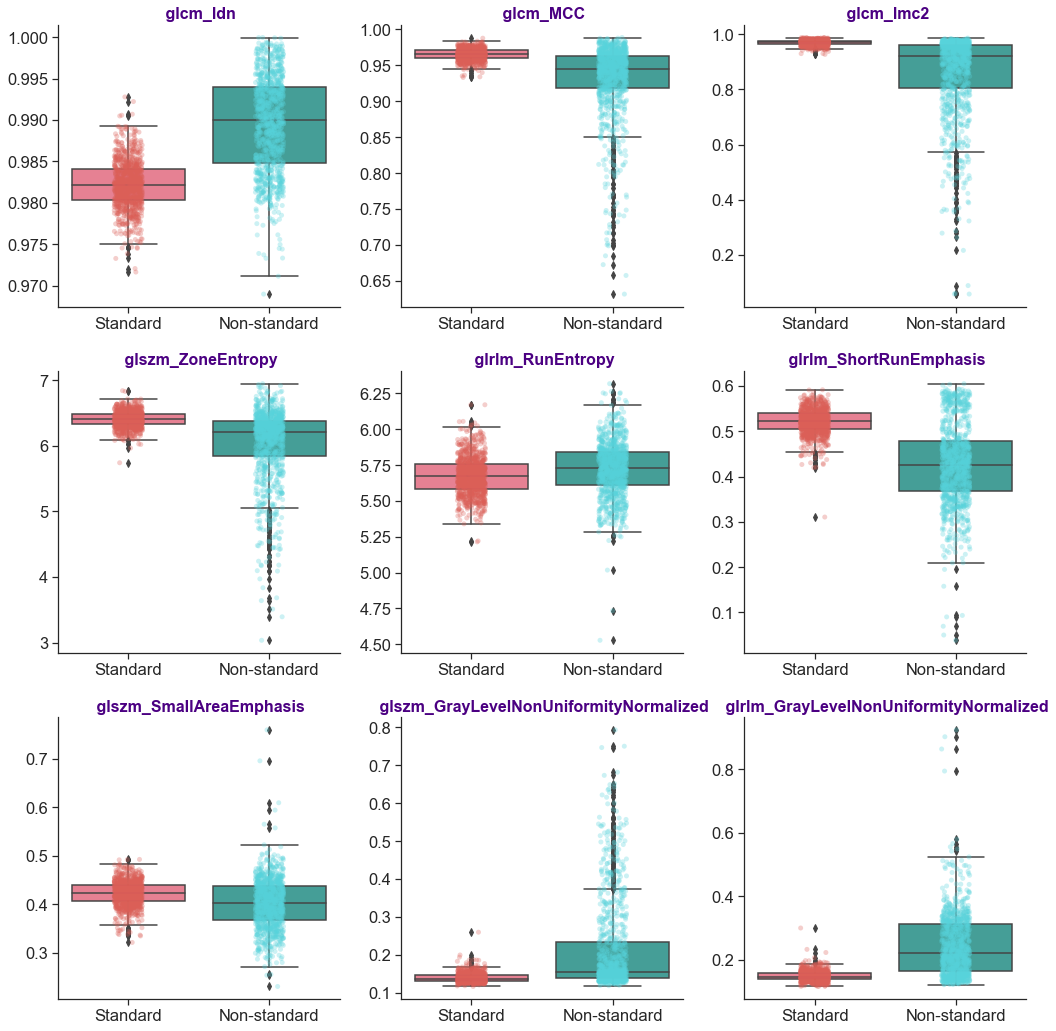

In [27]:
sns.set_theme(style="ticks", font_scale=1.5)
g = sns.FacetGrid(mdf, col="RF", sharex=False, sharey=False, height=5, col_wrap=3) #height=4, aspect=.5
g.map(sns.boxplot, "Type", "value", order=["Standard", "Non-standard"], palette="husl")
g.map(sns.stripplot, "Type", "value", marker="o", alpha=0.3, palette="hls", jitter=True, order=["Standard", "Non-standard"])
for ax in g.axes.flat:
    # Make x and y-axis labels slightly larger
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    #ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')

    # Make title more human-readable and larger
    if ax.get_title():
        ax.set_title(ax.get_title().split('=')[1],
                     fontsize=16, color = 'indigo', weight='bold')

In [28]:
lists9 = ['glcm_Idn','glcm_MCC','glcm_Imc2','glszm_ZoneEntropy',
           'glrlm_RunEntropy','glrlm_ShortRunEmphasis','glszm_SmallAreaEmphasis',
           'glszm_GrayLevelNonUniformityNormalized', 'glrlm_GrayLevelNonUniformityNormalized']
stn_RF = stn[lists9].transpose()
#stan_RF = stn_RF.loc['mean',:]
# stan_RF = stan_RF.astype(float)
stn_RF.insert(0,'Type','Standard')
stn_RF = stn_RF.drop(['mean','STD','CV'], axis=1)

nstn_RF = nstn[lists9].transpose()
#nstn_RF = nstn_RF.loc['mean',:]
# nstn_RF = nstn_RF.astype(float)
nstn_RF.insert(0,'Type','Non-standard')
nstn_RF = nstn_RF.drop(['mean','STD','CV'], axis=1)

cdf = pd.concat([stn_RF, nstn_RF], axis=0)    
cdf.index.names = ['RF']
#stan_RF = stan_RF.set_index('col1').T.rename_axis('RF').rename_axis(None, 1)
# stan_RF.T.set_axis(["category", "product", "price"], axis=1, inplace=False).rename_axis('RF',axis=0)
cdf.reset_index(inplace=True)

mdf = pd.melt(cdf, id_vars=['RF', 'Type'])
mdf['value'] = mdf['value'].astype(float)

<Figure size 2160x1440 with 0 Axes>

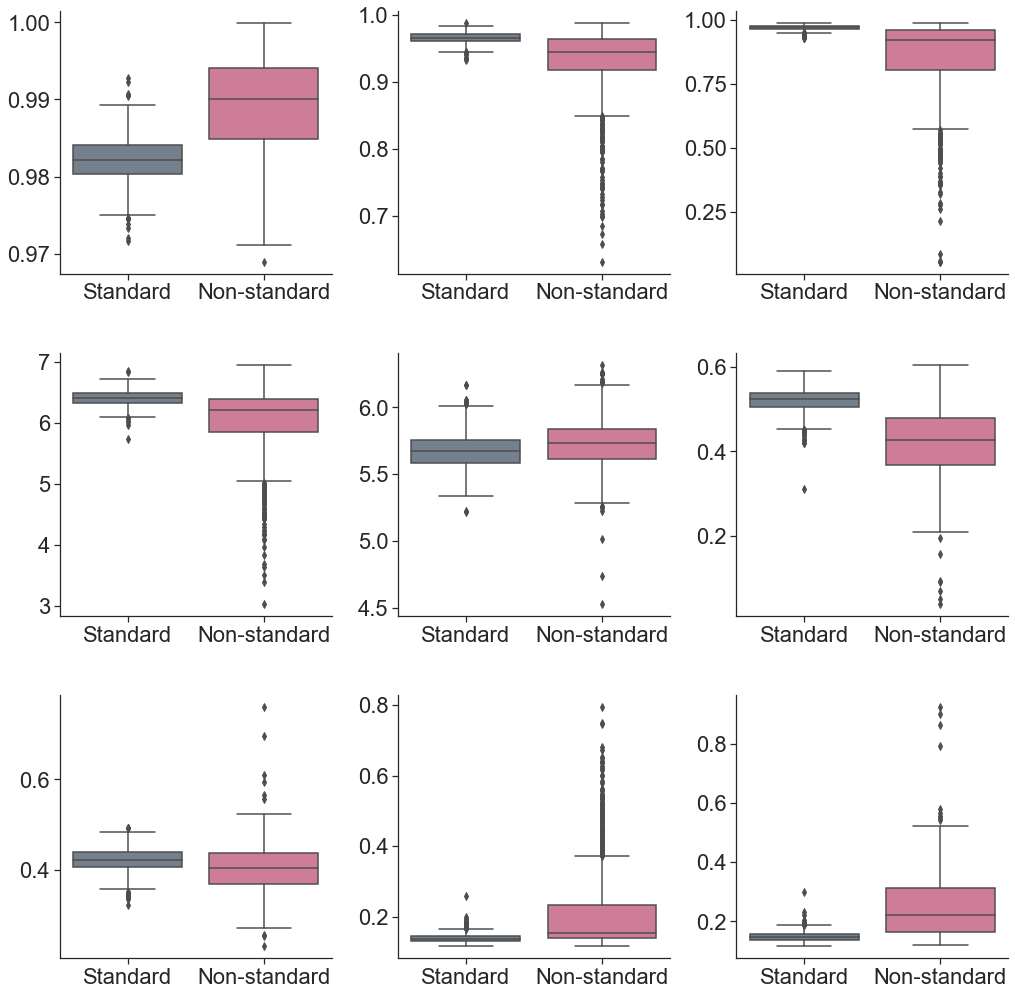

In [43]:
plt.figure(figsize=(30, 20))
colors1 = ['slategray','palevioletred']
colors2 = ['darkorchid','darkslateblue']
sns.set_theme(style="ticks", font_scale=2)
g = sns.FacetGrid(mdf, col="RF", sharex=False, sharey=False, height=5, col_wrap=3) #height=4, aspect=.5
g.map(sns.boxplot, "Type", "value", order=["Standard", "Non-standard"], palette = colors1)
#g.map(sns.stripplot, "Type", "value", marker="o", alpha=0.2, palette = colors1, jitter=True, order=["Standard", "Non-standard"])
for ax in g.axes.flat:
    # Make x and y-axis labels slightly larger
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(None)
    #ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')

    # Make title more human-readable and larger
#     if ax.get_title():
#         ax.set_title(ax.get_title().split('=')[1],
#                      fontsize=16, color = 'indigo', weight='bold')

In [27]:
from scipy.stats import shapiro
  
# conduct the  Shapiro-Wilk Test
shapiro(stn['glcm_Idn'].iloc[:1000])

ShapiroResult(statistic=0.9730817675590515, pvalue=1.1673614548970979e-12)

C:\Users\user\anaconda3\envs\torch\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\envs\torch\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='glcm_Imc2', ylabel='Density'>

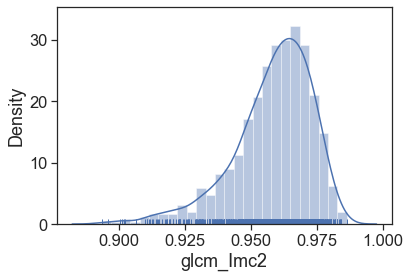

In [28]:
sns.distplot(stn['glcm_Imc2'].iloc[:1000], kde=True, rug=True)